# Entrenamiento de una red SkinLesNet para clasificación de imágenes de lesiones de piel

En este Notebook se muestra cómo definir y entrenar una red [SkinLesNet](https://github.com/azeemchaudhary/SkinLesNet-Model/blob/main/SkinLesNet_Project.ipynb) para clasificación de imágenes de lesiones de piel en dos clases: maligno (1) y benigno (0). Se usa el conjunto de datos de ISIC 2018, 2019 y 2020 descargados desde el siguiente enlace de [Kaggle](https://www.kaggle.com/competitions/isic-2024-challenge/discussion/515356).

## Importación de librerías

In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
from torchvision.transforms import v2

from tqdm import tqdm

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Parámetros

In [2]:
IMAGE_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 50
DEVICE = torch.device("mps")

## Carga de las imágenes de entrenamiento y de validación

Cargamos las imágenes de entrenamiento  y las guardamos en una lista, cada una de ellas dentro de un diccionario junto con su respectiva etiqueta. Además, transformamos las imágenes para que tengan un tamaño de 64 píxeles y normalizamos sus valores. El conjunto de validación y de test serán particiones del de entrenamiento. Caragmos tantas imágenes de una clase como de la otra para que no haya problemas de desbalanceo.

In [3]:
transformations = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE))
])

In [4]:
DATA_DIR = '/Users/alzorrcarri/skin_lesion_training_images'

dataset = []
name_files = os.listdir(DATA_DIR)

for file in name_files:
    if file.endswith('.jpg'):
        image = os.path.join(DATA_DIR, file)
        image = torch.tensor(plt.imread(image), dtype=torch.float32)
        image = torch.transpose(image, 0, 2)
        dataset.append({'image': image/255.0, 'label': 1})

In [5]:
malignant = len(name_files)
print(malignant)

5768


In [6]:
len(dataset)

5768

In [7]:
METADATA_FILE = '/Users/alzorrcarri/ISIC2018 Challenge/train-metadata.csv'
DATA_DIR = '/Users/alzorrcarri/ISIC2018 Challenge/train-image/image'
metadata = pd.read_csv(METADATA_FILE, header=0)

bening = 0
idx = 0
while bening <= malignant and idx < len(metadata):
    _, isic_id, patient_id, label = metadata.iloc[idx,]
    if label == 0.0:
        # Cargamos la imagen de la lesión si existe
        image = os.path.join(DATA_DIR, isic_id + '.jpg')
        if not os.path.exists(image):
            idx += 1
            continue
        image = torch.tensor(plt.imread(image), dtype=torch.float32)
        # Hacemos el resto de transformaciones necesarias
        image = torch.transpose(image, 0, 2)
        image = transformations(image)/255.0
        dataset.append({'image': image, 'label': 0})
        bening += 1
    idx += 1

In [8]:
print([malignant*100.0/(malignant+bening), bening*100.0/(malignant+bening)])

[49.99566611770824, 50.00433388229176]


In [9]:
len(dataset)

11537

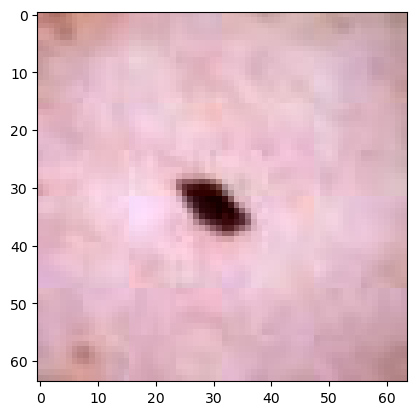

In [10]:
plt.imshow(dataset[0]['image'].permute(1, 2, 0))

In [11]:
for data in dataset:
    assert data['image'].shape == (3, IMAGE_SIZE, IMAGE_SIZE), f"Unexpected image shape in: {data['image'].shape}"
    assert data['label'] in [0, 1], f"Unexpected label value: {data['label']}"

In [12]:
random.shuffle(dataset)

In [13]:
train_loader = DataLoader(dataset[0:int(0.8*len(dataset))], batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(dataset[int(0.8*len(dataset)):int(0.9*len(dataset))], batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset[int(0.9*len(dataset)):], batch_size = BATCH_SIZE, shuffle = True)

In [14]:
print(len(train_loader), len(val_loader), len(test_loader))

289 37 37


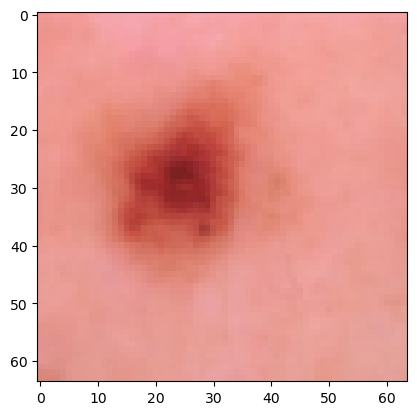

In [15]:
plt.imshow(train_loader.dataset.__getitem__(2)['image'].permute(2,1,0))

## Definición y entrenamiento de la red SkinLesNet

Definimos la clase que representa la red SkinLesNet y la entrenamos con las imágenes de entrenamiento. Para ello, usamos el optimizador Adam y la función de pérdida de entropía cruzada binaria, con pesos según la clase, ya que es un problema desbalanceado. La tasa de aprendizaje toma un valor inicial de 0.001, que irá disminuyendo en un facttor de 0.5 según el valor de la función de pérdida durante el entrenamiento, para que haya una mejor aproximación al valor óptimo de los parámetros de la red.

In [16]:
class SkinLesNet(nn.Module):
    def __init__(self, IMAGE_SIZE):
        super(SkinLesNet, self).__init__()
        # 1st Convolutional Input Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 2nd Convolutional Input Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # 3rd Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
        # 4th Convolutional Layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        self.dropout1 = nn.Dropout(0.5)

        self.flatten = nn.Flatten()
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16), 64)  # Adjusting for downsampling
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = self.dropout1(x)
        
        x = self.flatten(x)
        
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.softmax(self.fc2(x), dim=1)
        
        return x

In [17]:
skinlesnet = SkinLesNet(IMAGE_SIZE).to(DEVICE)

optimizer = optim.Adam(skinlesnet.parameters(), lr=0.001)
loss = nn.CrossEntropyLoss(weight=torch.tensor([bening/(bening+malignant), malignant/(bening+malignant)])).to(DEVICE)
lr_sch = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                        patience=1, threshold=0.0001, threshold_mode='rel', 
                                        cooldown=0, min_lr=0, eps=1e-15, verbose=False)

/opt/anaconda3/envs/tfm/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Definimos la función `calculate_accuracy` para calcular el accuracy de la red durante el entrenamiento, que lo calcula considerando que las predicciones del modelo de los targets y el conjunto de labels se cargan como tensores durante el entrenamiento.

In [18]:
def calculate_accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    return correct / target.size(0)

### Entrenamiento

In [19]:
loss_train_values = []
loss_val_values = []
accuracy_train_values = []
accuracy_val_values = []
lr_values = [] 

for epoch in range(EPOCHS):
    skinlesnet.train()

    epoch_loss = 0.0
    epoch_accuracy = 0.0

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images_batch = batch['image'].to(DEVICE)
        labels_batch = batch['label'].to(DEVICE).long()
        optimizer.zero_grad(set_to_none=True)
        output = skinlesnet(images_batch)
        loss_value = loss(output, labels_batch)
        loss_value.backward()
        optimizer.step()
        epoch_loss += loss_value.item()
        epoch_accuracy += calculate_accuracy(output, labels_batch)
        progress_bar.set_postfix(loss=epoch_loss / (step + 1), accuracy=epoch_accuracy / (step + 1))

    loss_train_values.append(epoch_loss / len(train_loader))
    accuracy_train_values.append(epoch_accuracy / len(train_loader))
    lr_values.append(lr_sch.get_last_lr()[0])
    lr_sch.step(epoch_loss / len(train_loader))

    if (epoch+1) % 5 == 0:
        skinlesnet.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        
        with torch.no_grad():
            for step, batch in enumerate(val_loader):
                images_batch = batch['image'].to(DEVICE)
                labels_batch = batch['label'].to(DEVICE).long()
                output = skinlesnet(images_batch)

                loss_value = loss(output, labels_batch)
                val_loss += loss_value.item()
                val_accuracy += calculate_accuracy(output, labels_batch.long())

        loss_val_values.append(val_loss / len(val_loader))
        accuracy_val_values.append(val_accuracy / len(val_loader))

        print(f"Validation accuracy: {val_accuracy / len(val_loader)}")


Epoch 4: 100%|██████████| 289/289 [00:03<00:00, 88.55it/s, accuracy=0.949, loss=0.362]


Validation accuracy: 0.9586148648648649


Epoch 9: 100%|██████████| 289/289 [00:03<00:00, 90.07it/s, accuracy=0.968, loss=0.344]


Validation accuracy: 0.96875


Epoch 14: 100%|██████████| 289/289 [00:03<00:00, 88.00it/s, accuracy=0.975, loss=0.337]


Validation accuracy: 0.9695945945945946


Epoch 19: 100%|██████████| 289/289 [00:03<00:00, 88.79it/s, accuracy=0.979, loss=0.333]


Validation accuracy: 0.9780405405405406


Epoch 24: 100%|██████████| 289/289 [00:03<00:00, 91.74it/s, accuracy=0.983, loss=0.33] 


Validation accuracy: 0.9797297297297297


Epoch 29: 100%|██████████| 289/289 [00:03<00:00, 89.36it/s, accuracy=0.986, loss=0.327]


Validation accuracy: 0.9839527027027027


Epoch 34: 100%|██████████| 289/289 [00:03<00:00, 89.14it/s, accuracy=0.989, loss=0.324]


Validation accuracy: 0.9831081081081081


Epoch 39: 100%|██████████| 289/289 [00:03<00:00, 90.33it/s, accuracy=0.99, loss=0.323] 


Validation accuracy: 0.9881756756756757


Epoch 44: 100%|██████████| 289/289 [00:03<00:00, 89.43it/s, accuracy=0.991, loss=0.322]


Validation accuracy: 0.9864864864864865


Epoch 49: 100%|██████████| 289/289 [00:03<00:00, 90.36it/s, accuracy=0.991, loss=0.322]


Validation accuracy: 0.987331081081081


Guardamos el modelo y los valores de loss y accuracy durante el entrenamiento de la red.

In [20]:
# Guardamos el modelo
torch.save(skinlesnet.state_dict(), 'skinlesnet_ISIC2016_trained.pth')

# Escribir los valores de loss y accuracy para cada una de las épocas en un fichero
empty_string = ""
with open('skinlesnet_ISIC2016_training_data.csv', 'w') as f:
    f.write('epoch,loss_train,loss_val,accuracy_train,accuracy_val,lr\n')
    i = 0
    for epoch in range(EPOCHS):
        if (epoch+1) % 5 == 0:
            f.write(f"{epoch},{loss_train_values[epoch]},{loss_val_values[i]},{accuracy_train_values[epoch]},{accuracy_val_values[i]},{lr_values[epoch]}\n")
            i+=1
        else:
            f.write(f"{epoch},{loss_train_values[epoch]},{empty_string},{accuracy_train_values[epoch]},{empty_string},{lr_values[epoch]}\n")

## Prueba del clasificador con el conjunto de test

Finalmente, ponemos a prueba el clasificador entrenado sobre un conjunto de imágenes de test. Evaluamos el rendimiento del clasificador sobre este conjunto calculando distintas métricas de evaluación.

In [21]:
# Calculamos la matriz de confusión con los datos de validación
skinlesnet.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for step, batch in enumerate(test_loader):
        images_batch = batch['image'].to(DEVICE)
        labels_batch = batch['label'].to(DEVICE).long()
        y_true += labels_batch.tolist()
        output = skinlesnet(images_batch)
        _, predicted = torch.max(output, 1)
        y_pred += predicted.tolist()

In [22]:
# Calculamos las métricas de evaluación de la clasificación
print("SkinLesNet ISIC2016\n")
accuracy_val = accuracy_score(y_true, y_pred)
print(f"Final accuracy validation: {accuracy_val}")
precision_val = precision_score(y_true, y_pred)
print(f"Final precision validation: {precision_val}")
recall_val = recall_score(y_true, y_pred)
print(f"Final recall validation: {recall_val}")
f1_val = f1_score(y_true, y_pred)
print(f"Final f1 validation: {f1_val}")
conf_matrix = confusion_matrix(y_true, y_pred)
print(f"Final confusion matrix validation: {conf_matrix}")

SkinLesNet ISIC2016

Final accuracy validation: 0.9835355285961872
Final precision validation: 0.9759036144578314
Final recall validation: 0.9912587412587412
Final f1 validation: 0.9835212489158717
Final confusion matrix validation: [[568  14]
 [  5 567]]
